In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM  # 修改这一行
#倒入一些必要的库

In [83]:
feanum=10#一共有多少特征
window=5#时间窗设置
df1=pd.read_excel('data.xlsx',0) #读取数据，0对应第一支股票，1对应第二只，以此类推
df1=df1.iloc[0:-10,1:11]
df1.tail()
df1.replace('--', pd.NA, inplace=True)# 将'--'转换为NaN
df1 = df1.apply(pd.to_numeric, errors='coerce')# 将NaN值用均值替代
df1.fillna(df1.mean(), inplace=True)

In [84]:
from sklearn import preprocessing#进行归一化操作
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
df.tail()

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数
6920,0.726131,0.727933,0.731635,0.739630,0.575166,0.115054,0.232047,0.171329,0.031179,0.305731
6921,0.753180,0.749500,0.756293,0.754317,0.556010,0.100000,0.223544,0.170704,0.030051,0.282163
6922,0.747541,0.764432,0.757440,0.765046,0.549585,0.164516,0.211400,0.163855,0.028410,0.277566
6923,0.774027,0.766644,0.778084,0.770128,0.540825,0.078495,0.128394,0.100224,0.017282,0.198801
6924,0.751490,0.747842,0.759733,0.758269,0.515360,0.072760,0.130109,0.099216,0.017487,0.194537


In [85]:
#技术问题 重新对列做一个排序
order = ['开盘', '最高', '最低', '涨幅','振幅', '总手', '金额','换手%','成交次数','收盘']
df = df[order]
df.tail()

,开盘,最高,最低,涨幅,振幅,总手,金额,换手%,成交次数,收盘
6920,0.726131,0.727933,0.731635,0.575166,0.115054,0.232047,0.171329,0.031179,0.305731,0.739630
6921,0.753180,0.749500,0.756293,0.556010,0.100000,0.223544,0.170704,0.030051,0.282163,0.754317
6922,0.747541,0.764432,0.757440,0.549585,0.164516,0.211400,0.163855,0.028410,0.277566,0.765046
6923,0.774027,0.766644,0.778084,0.540825,0.078495,0.128394,0.100224,0.017282,0.198801,0.770128
6924,0.751490,0.747842,0.759733,0.515360,0.072760,0.130109,0.099216,0.017487,0.194537,0.758269


In [86]:
# 处理数据，将原始数据改造为LSTM网络的输入
stock = df
seq_len = window
amount_of_features = len(stock.columns)  # 有几列
data = stock.values  # 表格转化为矩阵
sequence_length = seq_len + 1  # 序列长度+1
result = []

for index in range(len(data) - sequence_length):  # 循环 数据长度-时间窗长度 次
    result.append(data[index: index + sequence_length])  # 第i行到i+5

result = np.array(result)  # 得到样本，样本形式为 window*feanum
cut = 100  # 分训练集测试集，最后cut个样本为测试集
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:, -1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:, -1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))


In [87]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (6819, 5, 10)
y_train (6819,)
X_test (100, 5, 10)
y_test (100,)


In [88]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

d = 0.0001
model = Sequential()  # 建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))  # 建立LSTM层
model.add(Dropout(d))  # 建立的遗忘层
model.add(LSTM(16, return_sequences=False))  # 建立LSTM层，不需要再次指定input_shape
model.add(Dropout(d))  # 建立的遗忘层
model.add(Dense(4, activation='relu'))   # 建立全连接层，移除init参数
model.add(Dense(1, activation='relu'))  # 建立全连接层，移除init参数
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=256)  # 训练模型，使用epochs代替nb_epoch

Epoch 1/100
27/27 [==============================] - 13s 35ms/step - loss: 0.0157 - accuracy: 2.9330e-04
Epoch 2/100
27/27 [==============================] - 1s 33ms/step - loss: 7.7799e-04 - accuracy: 2.9330e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 3.2718e-04 - accuracy: 2.9330e-04
Epoch 4/100
27/27 [==============================] - 1s 39ms/step - loss: 2.5617e-04 - accuracy: 2.9330e-04
Epoch 5/100
27/27 [==============================] - 1s 33ms/step - loss: 2.4095e-04 - accuracy: 2.9330e-04
Epoch 6/100
27/27 [==============================] - 1s 53ms/step - loss: 2.2609e-04 - accuracy: 2.9330e-04
Epoch 7/100
27/27 [==============================] - 1s 41ms/step - loss: 2.2572e-04 - accuracy: 2.9330e-04
Epoch 8/100
27/27 [==============================] - 1s 31ms/step - loss: 2.1899e-04 - accuracy: 2.9330e-04
Epoch 9/100
27/27 [==============================] - 1s 50ms/step - loss: 2.1416e-04 - accuracy: 2.9330e-04
Epoch 10/100
27/27 [===========

In [89]:
#总结模型
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 64)             19200     
                                                                 
 dropout_12 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                5184      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 4)                 68        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 24,457
Trainable params: 24,457
Non-trai

In [90]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train

214/214 [==============================] - 3s 7ms/step


Text(0.5, 1.0, 'Train Data')

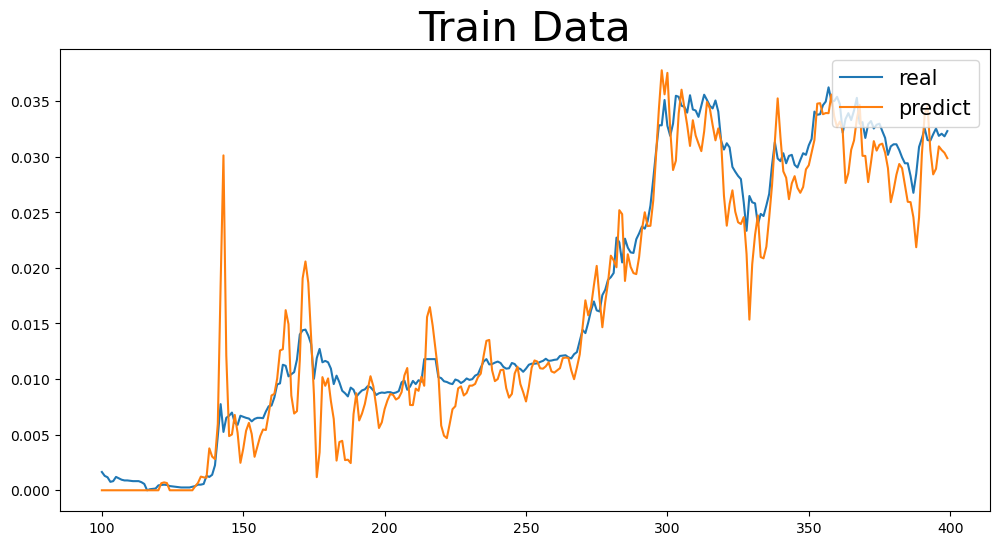

In [91]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:400,0].plot(figsize=(12,6))
draw.iloc[100:400,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [92]:
#在测试集上的预测
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

4/4 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Test Data')

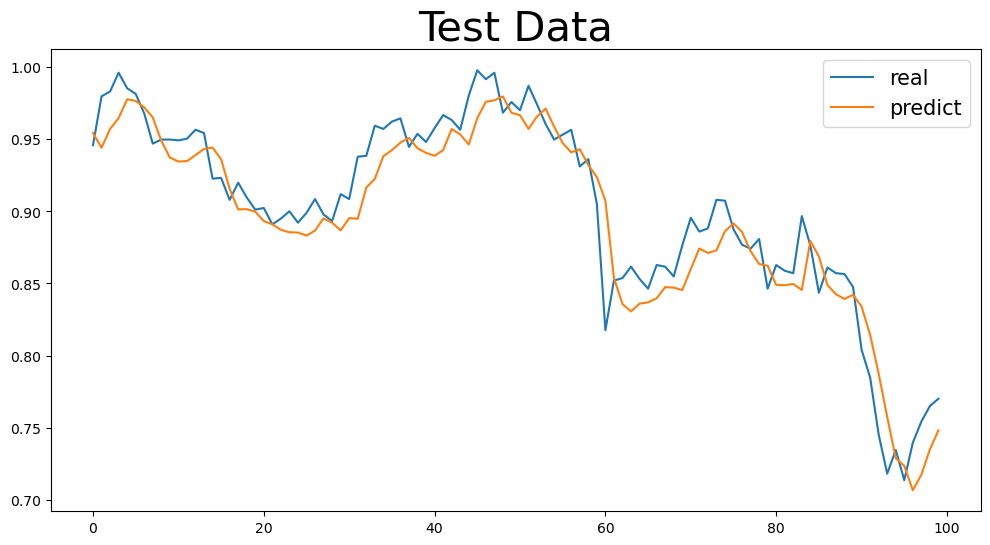

In [93]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

In [94]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict, y_test) )
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

训练集上的MAE/MSE/MAPE
0.006318995319174277
0.00010666426498561175
nan
测试集上的MAE/MSE/MAPE
0.017180214522788187
0.00047266070404772785
1.959236227948707
预测涨跌正确: 0.46464646464646464


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27972\2426382388.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27972\2426382388.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
